In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb # this notebook is for plotting
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['font.size'] = 7 #
plb.rcParams['font.stretch'] =  0
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
import warnings
warnings.filterwarnings('ignore')

In [2]:
def filter_mtrx_linear(lmr_mtrx,lc,hc):
    """fiter left-right data using a bandpass filter"""
    return np.apply_along_axis(flb.butter_bandpass_filter,1,lmr_mtrx,lc,hc,0.021)

def filter_mtrx_nonlinear(lmr_mtrx,kernel_size=12,mysize=21):
    """filter using a median filter followed by wiener filter"""
    from scipy import signal
    trenddata = np.apply_along_axis(signal.medfilt,1,lmr_mtrx,kernel_size = kernel_size)
    detrend = lmr_mtrx-trenddata
    detrend[np.isnan(detrend)] = 0
    return np.apply_along_axis(signal.wiener,1,detrend,mysize =mysize)
    
def detect_saccades(lmr_mtrx,p0=0.5,p1=2,thresh=0.2,linear = True):
    """filter data then detect saccades over some threshold"""
    if linear:
        sac_band = filter_mtrx_linear(lmr_mtrx,p0,p1)
    else:
        sac_band = filter_mtrx_nonlinear(lmr_mtrx,p0,p1)
    event_lists = [flb.idx_by_thresh(sweep,thresh) for sweep in abs(sac_band)]
    event_lists = [[event for event in event_list if 
                    (len(event)>0) and not(event is None)] for event_list in event_lists if event_list]
    return event_lists,sac_band

def convert_events_to_mtrx(event_lists,output_shape,scalings = 1):
    """loop through the detected events to create a matrix of binary
    classified samples - output shape should match the dimensions matrix
    of wingstroke data that was input to the detect_saccades function"""
    event_mtrx = np.zeros(output_shape)
    if type(scalings) is list:
        for i,(elist,slist) in enumerate(zip(event_lists,scalings)):
            for event,scailing in zip(elist,slist):
                event_mtrx[i,event] = scailing
        return event_mtrx
    for i,elist in enumerate(event_lists):
        for event in elist:
            event_mtrx[i,event] = scalings
    return (event_mtrx > 0)

def get_putative_saccade_mtrx(p0,p1,thresh,linear = True):
    """apply detect_saccades and then convert to matrix use to evaluate true positive
    and false positive rates"""
    putative_saccades = detect_saccades(ground_truth_lmr,p0,p1,thresh,linear)
    putative_saccade_mtrx = convert_events_to_mtrx(putative_saccades[0],np.shape(ground_truth_lmr))
    return (putative_saccade_mtrx > 0)

In [3]:
#store the selected filter setting in a dictionary. Pickle for later use
import cPickle
#with open('chosen_fiter_settings.cpkl','wb') as f:
#    cPickle.dump(chosen_settings,f)
with open('chosen_filter_settings.cpkl','rb') as f:
    chosen_settings = cPickle.load(f)

IOError: [Errno 2] No such file or directory: 'chosen_filter_settings.cpkl'

In [3]:
ls

01_extract_metadata.ipynb
02_apply_saccade_filter_roll_pitch_yaw.ipynb
02_temporal_microstructure_yaw.ipynb
03_rotation_roll_pitch_yaw.ipynb
detected_saccades_nl_22H05.hdf5
figure4_layout.svg
figure4.svg
model_search.h5
open_loop_rotation_22H05_ptch_roll.hdf5
res.png
response_rasters.pdf
store.h5
testlayout_2.svg
testlayout.svg
trial_rasters_with_examples_sorted_by_behavior.pdf
Untitled1.ipynb
Untitled2.ipynb
Untitled.ipynb
yaw_translate_22H05.pdf
yaw_translate_22H05.svg


In [5]:
import h5py
mtd_22H05_pr = h5py.File('open_loop_rotation_22H05_ptch_roll.hdf5','r')

In [10]:
mtd_22H05_pr['normed_signals']['Ph0']

<HDF5 dataset "Ph0": shape (1834, 1150), type "<f8">

In [11]:
mtd_22H05_pr.keys()

[u'normed_signals',
 u'selected_signals',
 u'signal_means',
 u'signal_norms',
 u'sort_idx']

In [12]:
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[selection,:]
    elif signal in ['Ph0','Ph1','Ph2']:
        return np.array(mtd_22H05_pr['normed_signals'][signal][selection,:])*np.array(
                mtd_22H05_pr['signal_norms'][signal][selection])[:,None]
    else:
        return np.array(mtd_22H05_pr['normed_signals'][signal][selection,:])

In [14]:
trial_names = np.array(mtd_22H05_pr['selected_signals']['trial_names'])

In [16]:
set(trial_names)

{'pth_roll_0',
 'pth_roll_120',
 'pth_roll_150',
 'pth_roll_180',
 'pth_roll_210',
 'pth_roll_240',
 'pth_roll_270',
 'pth_roll_30',
 'pth_roll_300',
 'pth_roll_330',
 'pth_roll_60',
 'pth_roll_90',
 'step_roll_yaw_000',
 'step_roll_yaw_030',
 'step_roll_yaw_060',
 'step_roll_yaw_090',
 'step_roll_yaw_120',
 'step_roll_yaw_150',
 'step_roll_yaw_180',
 'step_roll_yaw_210',
 'step_roll_yaw_240',
 'step_roll_yaw_270',
 'step_roll_yaw_300',
 'step_roll_yaw_330'}

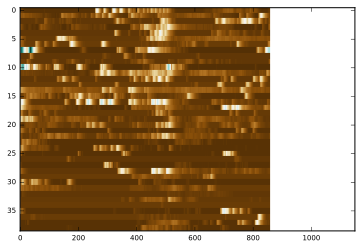

In [36]:
plb.imshow(get_selection_mtrx('hg1','step_roll_yaw_210'),aspect = 'auto',interpolation='nearest')

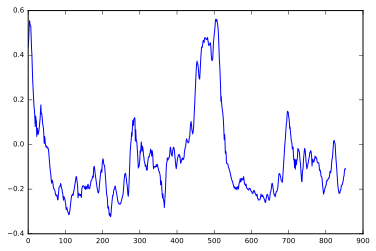

In [37]:
plb.plot(np.mean(get_selection_mtrx('hg1','step_roll_yaw_210'),axis = 0))